In [1]:
import numpy as np
%pylab inline
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Beta density (a,b)
def betaDensity(a,b,x):
    coeff = math.factorial(a - 1) * math.factorial(b - 1) / math.factorial(a + b - 1)
    res = x**(a - 1) * (1 - x)**(b - 1) / coeff
    return(res)

# Beta simulation via acceptance-rejection method
def betaSimulation(a,b):
    xmax = (a - 1)/(a + b - 2)
    fxmax = betaDensity(a, b, xmax)
    
    x = -1
    test = True
    while test:
        u = np.random.uniform()
        y = np.random.uniform()
        if u <= (betaDensity(a,b,y) / fxmax):
            x = y
            test = False
    return x

In [3]:
# Compare distribution estimations from above implementation and numpy
def verificationPlot(test, reference):
    dfSim = pd.DataFrame(test)
    dfPy = pd.DataFrame(reference)
    sns.distplot(dfSim, color="y", label= "Manual simulation")
    sns.distplot(dfPy, hist=False, label = "Numpy simulation")
    legend = plt.legend()
    return True

True

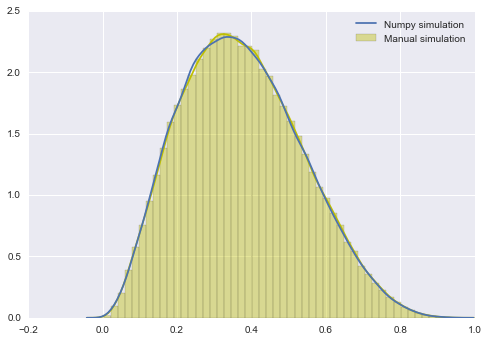

In [4]:
# Check Beta simulation
N = 200000
a = 3
b = 5

def multipleBetaSimulation(a, b, size = N):
    beta = []
    for i in range(N):
        beta.append(betaSimulation(a,b))
    return(beta)

test = multipleBetaSimulation(a, b, size = N)
reference = np.random.beta(a, b, size = N)

verificationPlot(test, reference)

In [5]:
# Bernouilli simulation
def bernouilliSimulation(p):
    u = np.random.uniform()
    x = -1
    if (u <= p): return(1)
    return(0)

# Geometric simulation
def geometricSimulation(p):
    test = True
    i = 1
    while test:
        ber = bernouilliSimulation(p)
        if ber == 1: test = False
        else: i = i + 1
    return(i - 1)

# Negative binomial simulation
def negBinSimulation(n, p):
    Y = []
    for i in range(n): Y.append(geometricSimulation(p))
    return(sum(Y))

True

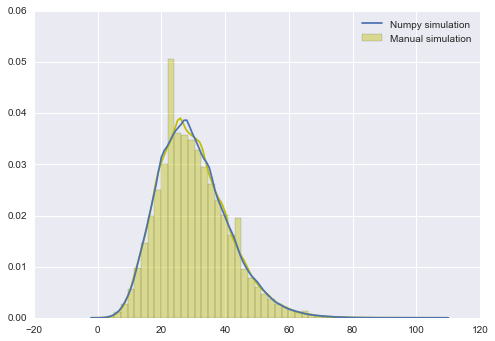

In [6]:
# Check negative binomial simulation
N = 200000
n = 10
p = 0.25

def multipleNegBinSimulation(n, p, size = N):
    negBin = []
    for i in range(N):
        negBin.append(negBinSimulation(n,p))
    return(negBin)

test = multipleNegBinSimulation(n, p, size = N)
reference = np.random.negative_binomial(n, p, size = N)

verificationPlot(test, reference)

In [7]:
# Gibbs Sampler implementation
# m1: 1st step capture
# m2: unique 2nd step capture
# m12: recapture
def gibbs_sampler(nbIter, manual = False, m1 = 22, m2 = 60, m12 = 11):
    mplus = m1 + m2
    mc = m1 + m2 + m12
    
    # Conditional simulations of p|M, x and M - m+|p, x
    # p|M,x ~ beta(mc + 1, 2*M  - mc + 1)
    # M - m+|p,x ~ NegBin(m+, 1 - (1 - p)**2)
    p = [] # 
    M = [] # In fact M - m+
    
    # Prior init
    p.append(np.random.uniform())
    
    # Iterations
    for t in range(nbIter):
        if manual:
            M.append(negBinSimulation(mplus, 1 - ((1 - p[t])**2)))
            p.append(betaSimulation(mc + 1,2*(M[t] + mplus) - mc + 1))
        else:
            M.append(np.random.negative_binomial(mplus, 1 - ((1 - p[t])**2)))
            p.append(np.random.beta(mc + 1,2*(M[t] + mplus) - mc + 1))
    M = np.array(M)   
    p = np.array(p)
    M = M + mplus
    print(scipy.stats.describe(M))
    print(scipy.stats.describe(p))
    return (M,p)

def resultsExploitation(resultats):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,8))
    dfM = pd.DataFrame(resultats[0])
    sns.distplot(dfM, ax = ax1, kde_kws={"color": "k", "lw": 1, "label": "M"})
    dfp = pd.DataFrame(resultats[1])
    sns.distplot(dfp, ax = ax2, kde_kws={"color": "k", "lw": 1, "label": "p"})
    legend = plt.legend()

In [8]:
# Python functions
pythonResults = gibbs_sampler(1000)

DescribeResult(nobs=1000, minmax=(82, 688), mean=219.232, variance=5084.6248008008006, skewness=1.985523171181266, kurtosis=6.215994960330544)
DescribeResult(nobs=1001, minmax=(0.058239580476060822, 0.99859182143563119), mean=0.23119646363612328, variance=0.0048105237091459205, skewness=1.601301719785892, kurtosis=14.709678624575396)


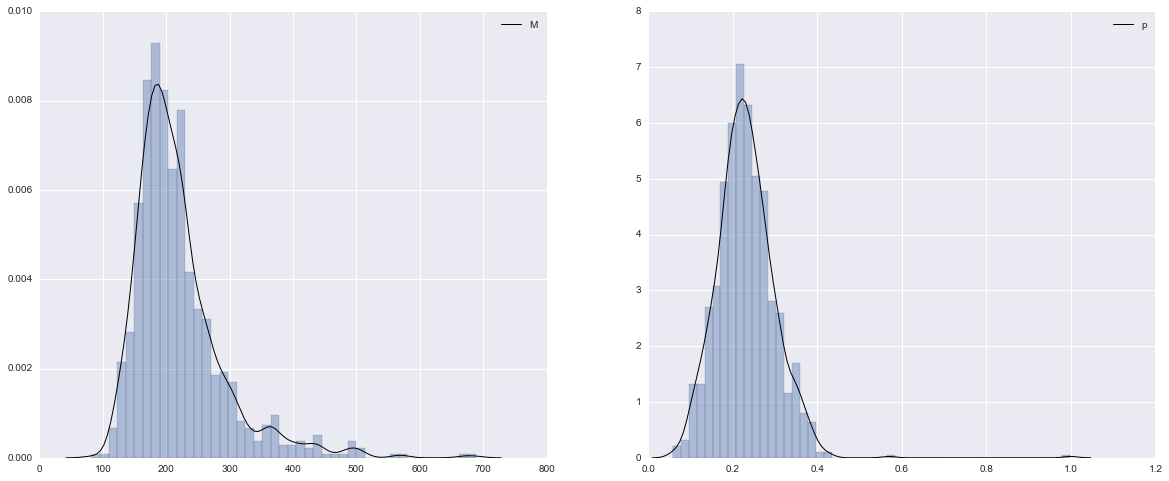

In [9]:
resultsExploitation(pythonResults)

In [ ]:
# Autocorrelograms
statsmodels.graphics.tsaplots.plot_acf(pythonResults[0], lags=200)

In [ ]:
# Trace
sns.tsplot(pythonResults[0][1:1000])

In [ ]:
# Own implementation of distributions
manualResults = gibbs_sampler(100000, manual=True)

In [ ]:
exploitationResultats(manualResults)

In [ ]:
statsmodels.graphics.tsaplots.plot_acf(manualResults[0], lags=200)

In [10]:
# Monte-Carlo error
def errorMC(nbItera, nbIteraGS, manuel = False, m1 = 22, m2 = 60, m12 = 11):
    # Results
    p = []
    M = []
    # nbItera Gibbs Sampler iterations
    # Within each GS, nbIteraGS are done
    for i in range(nbItera):
        tmp = gibbs_sampler(nbIteraGS, manuel, m1, m2, m12)
        M.append(mean(tmp[0]))
        p.append(mean(tmp[1]))
    print(scipy.stats.describe(M))
    print(scipy.stats.describe(p))
    return(M,p)

In [11]:
errorMC_python = errorMC(5000, 10000)

DescribeResult(nobs=10000, minmax=(104, 619), mean=202.3116, variance=2750.3767431143115, skewness=1.629058217740407, kurtosis=4.8045189135074144)
DescribeResult(nobs=10001, minmax=(0.07550473198729786, 0.56259250721059673), mean=0.2440919188038678, variance=0.0033853452003367321, skewness=0.18201583871206453, kurtosis=-0.025962756043826918)
DescribeResult(nobs=10000, minmax=(101, 473), mean=199.9402, variance=2257.6763915991596, skewness=1.2449792039069054, kurtosis=2.5655916978027307)
DescribeResult(nobs=10001, minmax=(0.090294235687033306, 0.47531086618919721), mean=0.24571107829025654, variance=0.0032561099545395187, skewness=0.2959370308027952, kurtosis=0.009926488124020416)
DescribeResult(nobs=10000, minmax=(104, 543), mean=200.42089999999999, variance=2370.1581590059009, skewness=1.24557185687433, kurtosis=2.6516023351064844)
DescribeResult(nobs=10001, minmax=(0.087172724614544131, 0.4696914446653267), mean=0.2458840149352948, variance=0.0033589726933005502, skewness=0.260814770